<span style="color:red;font-size:1.5em;font-weight:bold;background-color:yellow">Partie 1 - Importer les données et explorer les radiographies</span>

<span style="color:blue;font-size:1.2em;font-weight:bold">Mise en place</span>

In [1]:
# Module pour recharger un module sans redemarrer le kernel
# import importlib
%load_ext autoreload
%autoreload 2

In [2]:
# imports
import os
import numpy as np
import pandas as pd
from pathlib import Path
import gc
import matplotlib.pyplot as plt
from PIL import Image
import copy

# On utilise pytorch ici plutot que tensorflow
# Avantage: plus personnalisable VS Plus facile a utiliser 
# Définit les tenseurs, couches de neurones et algo d'opti (SGD,Adam)
import torch
import torch.nn as nn
import torch.optim as optim
# Pour créer une structure pour lire les images et les envoyer par paquet (batches) au GPU
from torch.utils.data import DataLoader
# Contient des architectures pré-entraînées (ResNet, VGG).
from torchvision import models

from sklearn.model_selection import train_test_split



In [3]:
# Sert à éviter les Warnings avec les transformations sur des vues en transformant 
# ces warning en erreur obligeant ainsi à ne travailler que sur des copies ou les originaux.

pd.set_option('mode.chained_assignment','raise')

In [4]:
# Ajoute le dossier datas_manipulation au sys.path. Remarque ne pas oublier le __init__.py dans le dossier datas_manipulation
import sys
# root_path = Path(__file__).resolve().parents[1] # Ne fonctionne pas sur notebook
ROOT_PATH = Path.cwd().parent
sys.path.append(str(ROOT_PATH))

In [5]:
# Fonctions personnelles

from notebooks.utils.dataset import BaseTransform, ImagesToDataset
from notebooks.utils.models import FeatureExtractor, BrainCancerClassifier
from notebooks.utils.analysis import ClusterManager
from notebooks.utils.training import Trainer, SslManager
from notebooks.utils.plotting.make_model_plots import plot_clustering
from notebooks.utils.data_manipulation import save_datas, combinaisonAB
from notebooks.utils.plotting.config_figures import save_figure


In [6]:
# Variables/paramètres globales

# Création dossier results
SAVE_PATH = ROOT_PATH.joinpath('datas/results')
Path.mkdir(SAVE_PATH,exist_ok = True)

# Pour la reproductibilité (similaire a random_state) 
# --> influence l'initialisation des poids ResNet et le mélange du DataLoader
torch.manual_seed(42)
np.random.seed(42)

# Config pour basculer sur le GPU si possible (50x plus rapide en deep learning que CPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {DEVICE}")
# Taille des paquets (en puissance de 2 pour s'aligner avec l'archi GPU: 2 4 8 16 32 64)
BATCH_SIZE = 16

# Config des images
IMG_SIZE = 224 # Résolution standard 
# Cas transfer learning avec ResNet: Les valeurs données sont les moyennes et ecarts type des 
# couleurs RGB dans ImageNet
IMG_MEAN = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]

RANDOM_STATE=42
N_JOBS=-1
N_FEATURES = 512 # Nombre de features issu des CNN,en 18,34 couches on a 512 features, 
# en 50,101 et 152 on passe a 2048 features, avec VGG16 on est 4096 
# et pour EfficientNet-BO c'est 1280 features
TEST_SIZE = 0.2
N_EPOCH = 10

Running on: cpu


In [7]:
# Dictionnaire de la confinguration globale du projet
project_config = {
    "model":"resnet34",
    "n_features":N_FEATURES,
    "n_jobs":N_JOBS,
    "batch":BATCH_SIZE,
    "device":DEVICE,
    "img_size":IMG_SIZE,
    "img_mean":IMG_MEAN,
    "img_std":IMG_STD,
    "test_size":TEST_SIZE,
    "random_state":RANDOM_STATE,
}

In [8]:
# Chemin des données brutes
DATAS_PATH = ROOT_PATH/"datas/raw/mri_dataset_brain_cancer_oc"

# Listing des fichiers qui composent les labellisés des non labellisés
# glob pour les fichiers et rglob si il y a des sous-dossiers
avec_labels_path = list((DATAS_PATH / "avec_labels").rglob("*.jpg"))
sans_label_path = list((DATAS_PATH / "sans_label").glob("*.jpg"))
project_config.update({"avec_label":len(avec_labels_path),"sans_label":len(sans_label_path)})

# Encodage des labels (0: normal, 1: cancer, -1: sans_label)
avec_labels_encoding = [1 if "cancer" in path.parts else 0 for path in avec_labels_path]
all_paths = avec_labels_path + sans_label_path
all_labels = avec_labels_encoding + ([-1] * len(sans_label_path))


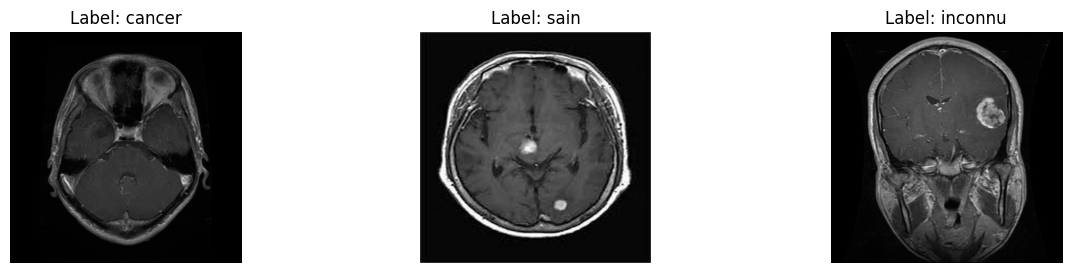

In [9]:
# Visualisation de quelques exemples
path_samples = [avec_labels_path[0], avec_labels_path[50], sans_label_path[0]]
label_samples = ["cancer","sain","inconnu"]

fig, axes = plt.subplots(1, len(path_samples), figsize=(15, 3))
for i,(path,label) in enumerate(zip(path_samples,label_samples)):
    image = Image.open(path)
    # L'image est un tensor, on le convertit en numpy array et on le transpose pour l'affichage
    # On dénormalise aussi l'image pour un affichage correct
    # img = image.numpy().transpose(1, 2, 0) * 0.5 + 0.5
    # axes[i].imshow(img.squeeze(), cmap='gray') # Use cmap='gray' for single channel images if needed
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')

plt.show()

In [10]:
print("=============== Contenu du dataset ================")
with open(
    DATAS_PATH/"Jeu de Données d'Images Cérébrales pour la Détection de Tumeurs.txt",
    "r",
    encoding="utf-8"
) as f:
    print(f.read())

=============== Contenu du dataset ================
Description

Ce jeu de données comprend un total de 1500 images :

    1400 images non étiquetées

    100 images étiquetées

Les images étiquetées sont réparties en deux catégories :

    Normal : Images de cerveaux sains.

    Cancer : Images de cerveaux présentant des signes de tumeurs.

Caractéristiques des Images

Toutes les images ont été redimensionnées à une taille standardisée de 512×512 pixels. Cette standardisation assure leur compatibilité avec divers pipelines de traitement d'images et d'apprentissage automatique. Elles sont enregistrées au format d'image courant JPEG (.jpg).
Applications Potentielles

Ce jeu de données peut être exploité pour un large éventail d'applications, notamment :

    🤖 L'entraînement et l'évaluation de divers modèles d'apprentissage profond (par exemple, DenseNet201, YOLOv8x/s, CNN, ResNet50v2, VGG-16, MobileNetV2).

    🔬 Le développement d'algorithmes de classification d'images pour la détecti

Le zip "**mri_dataset_brain_cancer_oc**" contient deux dossiers et un fichier texte qui résume le contenu du dataset:
- **sans_label/**: 1406 images non étiquetées
- **avec_labels/**: 100 images étiquetées

Dans le dossier avec label on trouve deux sous-dossiers:
- **Normal/** : 50 images de cerveaux sains.
- **Cancer/** : 50 images de cerveaux présentant des signes de tumeurs.

**Caractéristiques des images**

- Toutes les images ont été redimensionnées à une taille standardisée de 512×512 pixels. 
- Elles sont enregistrées au format d'image courant JPEG (.jpg).
- Poids moyen autour de 20 Ko
- Nomination hashé
- Noir et blanc
- Qualité des images variable (floue, saturée ...)
- Coupes variables (dessus, de face, de profil) avec prédominance des coupes du dessus (ou dessous?)
- Certaines images ont des cadres, des echelles, des caractéristiques d'imagerie (W,L, n°)

<span style="color:red;font-size:1.5em;font-weight:bold;background-color:yellow">Partie 2 - Pré-traitement et extraction des features</span>

Comme nous l'avions relevé, les images nécéssitent un pré traitement afin de pouvoir être utilisable. Elles ont la même structure externe (pixels, format, poids, nomination) mais leur contenu doit aussi être standardiser:
- normaliser la nuance de gris
- enlever les informations d'image dans les images (W,L,n°) ($\approx$ data leaking)
Une fois celà fait, il restera à transformer les images en données exploitable à savoir l'embedding visuel via ResNet.

<span style="color:blue;font-size:1.2em;font-weight:bold">Préparation et embedding</span>

<span style="color:orange;font-weight:bold"> *Remarque personnelle*: Il est interessant de s'appercevoir que Pytorch pousse à travailler au travers de subclass</span>

In [11]:
# # Chemin des données brutes
# DATAS_PATH = ROOT_PATH/"datas/raw/mri_dataset_brain_cancer_oc"

# # Listing des fichiers qui composent les labellisés des non labellisés
# # glob pour les fichiers et rglob si il y a des sous-dossiers
# avec_labels_path = list((DATAS_PATH / "avec_labels").rglob("*.jpg"))
# sans_label_path = list((DATAS_PATH / "sans_label").glob("*.jpg"))

# # Encodage des labels (0: normal, 1: cancer, -1: sans_label)
# avec_labels_encoding = [1 if "cancer" in path.parts else 0 for path in avec_labels_path]
# all_paths = avec_labels_path + sans_label_path
# all_labels = avec_labels_encoding + ([-1] * len(sans_label_path))

# ================= Nettoyage ========================
# plt.close()
del (
    #avec_labels_path, sans_label_path, avec_labels_encoding, # Réutilisés dans en supervisé
    path_samples,label_samples,image,fig,axes
)
gc.collect()

6540

<span style="color:purple;font-weight:bold">Extraction des features via ResNet</span>

Comme toujours, il est nécéssaire d'avoir des informations compréhensibles pour une machine pour qu'un modèle puisse performer (ce n'est donc pas le cas des images). Pour cela on va donc pré-traiter les images afin qu'elles partent d'une base commune (redimensionnement et normalisation).

On va ensuite utiliser un CNN (ResNet18 par exemple) auquel on retire la dernière couche (couche de classification) afin d'obtenir un extracteur de features et on fait passer toutes les images pour constituer un tableau dont les lignes représentent les images et les colonnes, les caractéristiques de ces images.

In [12]:
# Traitement des images
# Instanciation du pré traitement
transform = BaseTransform(mean=IMG_MEAN,std=IMG_STD,size=IMG_SIZE).preproc(train=False)
# Génration du dataset SANS les augmentations (train et test encore mélangé pour le moment)
full_dataset = ImagesToDataset(all_paths, all_labels, transform=transform)
# Génération du loader qui va fournir la donnée au GPU par batch
full_loader = DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Instanciation du modèle d'extraction des caractéristiques
# to(DEVICE) déplace les poids du modèle de la RAM/CPU vers la VRAM/GPU
extractor = FeatureExtractor(pretrained=True).to(DEVICE)
# Rend le comportement de certaines couches déterministes ==> indispensable pour l'embedding
extractor.eval()

# Extraction
features_list = []
labels_list = []

# Par défaut, Pytorch mémorise chaque calcul pour faire la retropropagation de gradient
# indispensable si entrainement or ici on souhaite juste lire, on desactive donc la mémoire.
with torch.no_grad():
    for images, labels, _ in full_loader:
        images = images.to(DEVICE)
        features = extractor(images) # (Batch, N_FEATURES)
        features_list.extend(features.cpu().numpy()) # GPU --> CPU + tenseurs --> tableau numpy
        labels_list.extend(labels.cpu().tolist())

# Mise sous forme de df
cols = [f"feature_{i}" for i in range(N_FEATURES)]
df_features = pd.DataFrame(features_list, columns=cols)
df_features['label'] = labels_list

In [13]:
# ================= Nettoyage et sauvegarde ========================
del full_dataset, full_loader, images, features, features_list, labels_list, cols
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# if not (SAVE_PATH/"df_features/df_features_no_supervised.csv").exists():
save_datas(df_features,SAVE_PATH,"df_features","unsupervised","parquet")

PosixPath('/home/shipoz/Documents/OPENCLASSROOMS/P7/livrable_P7/datas/results/df_features')

**Remarque**: Le gèle des couches convolutionnelles s'est faite en utilisant .eval() et .no_grad().
- eval() agit sur certaines couches comme le batch normalization qui a un comportement aléatoire afin de les rendre déterministe.
- no_grad() désactive la mémorisation de Pytorch ce qui l'empêche d'apprendre

In [14]:
df_features.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_503,feature_504,feature_505,feature_506,feature_507,feature_508,feature_509,feature_510,feature_511,label
0,0.000711,0.967595,0.341529,1.901165,0.957052,3.594041,1.203337,0.389920,0.420447,0.136591,...,0.397860,0.141049,0.005128,0.185610,0.775661,0.677914,0.303889,1.273226,0.953451,1
1,0.424082,0.343133,1.549181,3.534758,1.059536,1.690318,0.384711,0.404190,0.012817,1.010008,...,0.086452,0.576635,0.133820,0.174625,0.355586,0.689909,1.641374,1.027018,2.266930,1
2,0.675654,2.226976,0.932349,5.832372,1.212539,0.576981,0.037122,0.586905,0.789708,0.367418,...,0.394682,0.671208,0.159386,0.336243,0.265793,3.298335,0.623389,0.689923,0.839203,1
3,0.492489,1.867785,0.566270,3.990413,0.600058,0.658403,0.139563,0.024514,0.573939,0.230976,...,0.449933,0.919753,0.273202,1.060444,0.089835,1.702788,0.648243,1.465206,0.565843,1
4,0.112004,0.384682,1.264945,2.737785,0.332712,2.672765,0.376925,0.833677,0.213646,0.729568,...,0.218833,0.278125,0.545321,0.000000,1.831624,0.803235,0.703025,0.836682,1.709315,1


On a un df avec les 100 premiers elements les fortements labellisés: les 50 premiers sont les cancereux, les 50 suivants les sains et les 1406 après les inconnus

<span style="color:red;font-size:1.5em;font-weight:bold;background-color:yellow">Partie 3 - Analyse non supervisée</span>

Le but à cete étape est de confirmer que le CNN amputé employé est capable de caractériser correctement les images.

Pour cela on va on test le tableau de features obtenu, on utilise pour cela un reducteur de dimension et un cluster.
1. Le modèle de réduction de dimension va condenser l'information issu de l'ensemble des features en n_components qui vont servir de coordonnées spatiale.
    - Le PCA est une méthode linéaire qui cherche à faire pivoter les données pour trouver les axes de plus grande variance.
    - Le t-SNE est non-linéaire et cherche à conserver la structure locale (les voisins proches).
2. Le modèle de clustering va procéder au regroupement des images en cluster (groupe/classe...) en cohérance avec les informations des images.
    - KMeans divise l'espace en "cellules" autour de centres (centroïdes).
    - DBSCAN regarde si les points sont "serrés".

A la fin de ce process, on juge suivant l'ARI qui va valider la qualité des embeddings:
- Si le CNN (ResNet18 par exemple) est bon, les features extraites devraient avoir formé des lignes (caract des images) dont les tenseurs sont similaires suivant qui soient d'une classe ou de l'autre (sain/cancer).
- Si le clustering (KMeans ou DBSCAN) a regroupé correctement les images (score ARI -> 1) alors l'extraction de feature est validée, l'extracteur est utilisable

In [15]:
# gestionnaire de sauvegarde
unsupervised_manager = SslManager(
    "experiment_01",
    root_path=SAVE_PATH,
    extension_path="unsupervised"
)

In [16]:
# Dictionnaires des hyperparamètres des modèles
# Réduction de dimension
pca_dict = {
    "n_components": 50, # Nombre de dimensions finales. 
    # rq: si entre 0 et 1, on demande une proportion d'information a conserver
}
tsne_dict= {
    "n_components": 2, 
    "random_state": RANDOM_STATE, 
    "init": 'pca', #Comment placer les points au départ. 'pca' est plus stable que 'random'
    "learning_rate": 'auto',
    "n_jobs":N_JOBS
}
# umap_dict = {
#     "n_neighbors":15, # définit taille du voisinnage (entre 2-10 faible):focus sur la structure locale
#     # (entre 30-100 fort): focus sur la structure globale 
#     "min_dist":0.1, # densité des clusters (0.001-0.05 faible) compacte les clusters,
#     # (entre 0.2 a 0.5 fort): points plus étalé pour voir la topologie générale
#     "n_components":2,
#     "metric":"cosine", # méthdoe de calcul des distances
# }

# Clustering
kmeans_dict = {
    "n_clusters": 2, #Le nombre de groupes imposé.
    "random_state": RANDOM_STATE, 
    "n_init": 10,
    # init : "k-means++", # Placement intelligent, Centroides loin les uns des autres au départ.
    # max_iter: 300,
}
dbscan_dict = {
    "eps": 0.5, # Distance max pour que deux points == "voisins". Très sensible. défaut 0.5
    "min_samples": 5, # Nb min de points pour former un groupe. Si <5, tout devient un cluster
    # metric : "euclidean", # Regle de calcul des distance
    # algorithm : "auto", # Méthode de recherche des voisins
    # leaf_size : 30, # lié a algorithm "ball_tree". Impacte la vitesse
    "n_jobs" : N_JOBS
}

In [17]:
# Sauvegarde des hyperparamètres utilisés en non supervisée

unsupervised_config = project_config | {
    **pca_dict, 
    **tsne_dict, 
    # **umap_dict, 
    **kmeans_dict, 
    **dbscan_dict
}

unsupervised_manager.save_config(unsupervised_config)

# ================== Nettoyage =================
del unsupervised_config
gc.collect()

20

In [18]:
# Dictionnaire pour regrouper les nom des algo et les dictionnaires d'hyperparams
red_dict = {"pca":pca_dict,"tsne":tsne_dict} 
# probleme de dépence revoir plus tard pour ,"umap":umap_dict}
clust_dict = {"kmeans":kmeans_dict,"dbscan":dbscan_dict}

In [19]:
# Instanciation du Manager
analyzer = ClusterManager(df_features)


unsupervised_metrics = []
for red_key,red_value in red_dict.items():
    # ========= REDUCTION DE DIMENSION ==============
    reduction_dim = analyzer.reduce_dimensions(red_key,red_value) #type:ignore

    for clust_key,clust_value in clust_dict.items():
        # =========== CLUSTERING =====================
        df_cluster = analyzer.apply_clustering(red_key,clust_key,clust_value) #type:ignore
        
        # ========== EVALUATION DES SCORES ============
        # ARI (nécessite true_labels)
        ari_score = analyzer.evaluate_ari(f"cluster_{red_key}_{clust_key}")
        # Silhouette (compare les distances de clustering avec les distances init df_features)
        silhouette_score = analyzer.evaluate_silhouette(
            df_feature=df_features,
            method=f'cluster_{red_key}_{clust_key}'
        )
        
        # ======== SAUVEGARDE INDIVIDUELLE ================
        temp_metrics ={
            "reduction" : red_key,
            "algo" : clust_key,
            "ari" : ari_score,
            "silhouette" : silhouette_score
        }
        # Metriques
        unsupervised_manager.log_metrics(temp_metrics)
        unsupervised_metrics.append(temp_metrics)

In [20]:
# # Score
# for i in ["pca_kmeans","pca_dbscan","umap_kmeans","umap_dbscan"]:
#     ari_score = analyzer.evaluate_ari(f"cluster_{i}")
#     print(f"score de {i}: {ari_score:.4f}")
# # ari_score_kmeans = analyzer.evaluate_ari(method='cluster_kmeans')
# # ari_score_dbscan = analyzer.evaluate_ari(method='cluster_dbscan')
# # print(f"ARI (ONLY true_labels) :\nKMeans: {ari_score_kmeans:.4f}\nDBSCAN: {ari_score_dbscan:.4f}")
# # # print("Interprétation : ARI -> 1 == clustering a parfaitement retrouvé les classes Normal/Cancer.")

plot_unsupervised_xp01 sauvegardé dans /home/shipoz/Documents/OPENCLASSROOMS/P7/livrable_P7/datas/results/figures


,reduction,algo,ari,silhouette
0,pca,kmeans,0.243708,0.128608
1,pca,dbscan,0.000000,-1.000000
2,tsne,kmeans,0.285424,0.127201
3,tsne,dbscan,0.000000,-1.000000


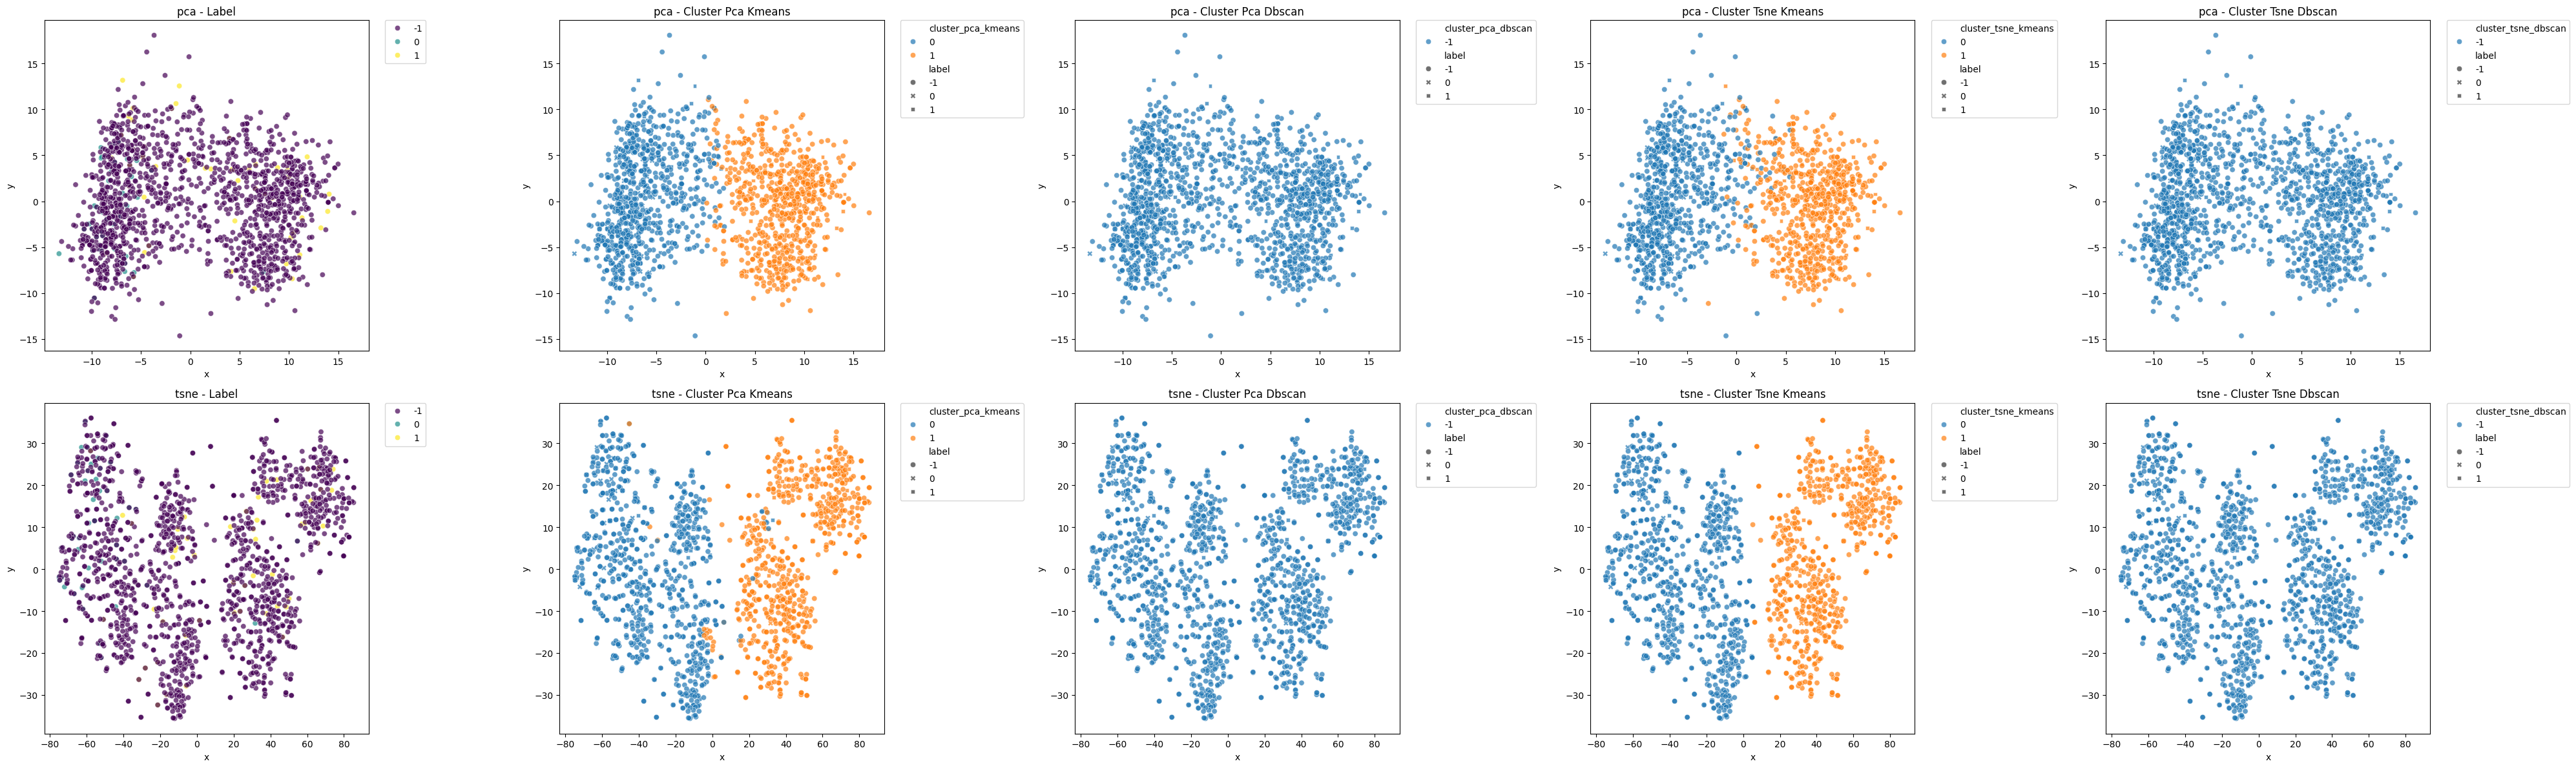

In [21]:
# ======================= SAUVEGARDE ET AFFICHAGE DES RESULTATS ======================
save_datas(
    df_cluster,
    SAVE_PATH/"unsupervised"/"experiment_01",
    filename="df_cluster",
    format ="parquet"
)

fig_cluster = plot_clustering(df_cluster, reduction_dim)
save_figure(
    "plot_unsupervised_xp01",
    SAVE_PATH/"figures"
)#, unsupervised_manager.root_path / "figures")

pd.DataFrame(unsupervised_metrics)

- Les scores ARI sont $\approx 0$ donc les algorithmes de regroupement ne distinguent pas une image cancereuse d'une image saine, elle range aléatoirement.
- **Le clustering (modèle non-supervisé) sur les features brutes du ResNet ne permet pas de distinguer les classes. Les labels faibles générés sont donc peu fiables et un entraînement supervisé est indispensable**

Ce résultat était probable car le ResNet est un CNN pré-entrainé sur ImageNet qui contient plus de 14 millions d'images haute résolution de 224 pixels sur divers catégories (plus de 1000) allant des animmaux, aux vehicules en passant pour des sous-catégories... Cependant il est probable que le cas particulier des radiographies, plus spécifiquement sur le cancer encéphalite est absent du jeu couplé aux qualité d'image variable et autres bruits, il en découle ainsi que ResNet reconnait dans les très grandes lignes (une tête, un humain?) mais est incapable de faire la distinction même partielle d'un cerveau sain VS cerveau avec un cancer.

In [22]:
# ================== Nettoyage =================
del (df_features, df_cluster, reduction_dim,
    analyzer, unsupervised_manager,
    temp_metrics
)
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

<span style="color:red;font-size:1.5em;font-weight:bold;background-color:yellow">Partie 4 - Appliquer la méthode supervisée</span>

La méthode supervisée revient à faire de la classification en guidant le modèle via les images labellisées, donc on a besoin d'un set regroupant les valeurs des features X et un set de target y. On ne peut pas repartir de *df_features* car c'était la df "échouée" de l'extracteur de base ResNet, de plus, le jeu ne comportait pas d'augmentation sur la partie à entrainer et était composé du jeu entier (labellisés et non labellisés), il faut donc remonter plus haut à savoir les images brutes labellisées et pour cela on va passer par les loaders qui vont se charger de fournir les batch d'image à partir de leur chemin:
- X sera donc composé des chemins des images (Series!) et y sera formé par les labels.
- On se constitue un jeu d'entrainement augmenté et un jeu de validation
- On créé les loaders
- On entraine le modèle en relevant les métriques d'intérêt

<span style="color:purple;font-weight:bold">Entrainement supervisé</span>

In [23]:
# gestionnaire de sauvegarde
supervised_manager = SslManager(
    "experiment_01",
    root_path=SAVE_PATH,
    extension_path="supervised"
)

In [24]:
supervised_config = project_config | {
    "num_classes":1,
    "init_threshold":0.99,
    "n_epoch":N_EPOCH,
    "init_learning_rate":1e-4,
}

In [25]:
# juste par confort
X = avec_labels_path
y = avec_labels_encoding

# Train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=TEST_SIZE, 
    stratify=y, 
    random_state=RANDOM_STATE
)

In [26]:
# Datasets & Loaders

# Instanciation de l'objet de redim, norm, augmentation
base_transform = BaseTransform(mean=IMG_MEAN,std=IMG_STD,size=IMG_SIZE)

# Constitution des sets d'entrainement augmentés et de validation non augmenté
train_dataset = ImagesToDataset(X_train, y_train, transform=base_transform.preproc(train=True))
test_dataset = ImagesToDataset(X_test, y_test, transform=base_transform.preproc(train=False))

# Loader des sets
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [27]:
# Instanciation du modèle et configuration de la pipeline d'entrainement

# Instanciation du classificateur + déplacement sur le device
model_classif = BrainCancerClassifier(num_classes=1).to(DEVICE)
# L'optimiseur ajuste les poids du modèle. 
# On met un learning rate (lr) faible car fine-tuning 
# (on ne veut pas détruire ce que ResNet sait déjà).
optimizer = optim.Adam(model_classif.parameters(), lr=1e-4)
# On instancie la loss (sans poids car dataset équilibré)
criterion = nn.BCELoss()

# Instanciation de la pipeline de training
trainer = Trainer(model_classif, DEVICE, criterion, optimizer, threshold=0.99)

In [28]:
# Boucle d'entraînement
temp_best_f2 = 0.0

print("====== Entraînement Supervisé (100 images) ==========")
for epoch in range(N_EPOCH):
    # ================= ENTRAINEMENT ================
    train_loss = trainer.train_epoch(train_loader) # on entraine sur le 80 images labellisées
    
    # ====================== EVAL =====================
    results = trainer.eval_metrics(test_loader) # on evalue sur les 20 images restantes label
    print(f"Epoch {epoch+1}/{N_EPOCH} | Loss: {train_loss:.4f} | f2: {results["f2"]:.4f}")
    
    # ================= SAUVEGARDE INDIVIDUELLE DES MÉTRIQUES =============
    temp_metrics ={
            "epoch" : epoch+1,
            "train_loss" : train_loss,
            "f2" : results["f2"],
            "precision" : results["precision"],
            "recall":results["recall"],
        }
    
    # ================ CHECKPOINT (SAVE SI MEILLEUR MODELE JUSQU'ICI) ===========
    temp_f2 = results["f2"]
    temp_state = {
        'epoch': epoch + 1,
        'state_dict': model_classif.state_dict(),
        'optimizer': optimizer.state_dict(),
        'f2': temp_f2,
        'config': supervised_config
    }
    
    if temp_f2 > temp_best_f2:
        # save du meilleur modele actuel
        supervised_manager.save_checkpoint(temp_state,is_best=True)
    else:
        # save de précaution mais pas meilleur actuel
        supervised_manager.save_checkpoint(temp_state, is_best=False)

====== Entraînement Supervisé (100 images) ==========
Epoch 1/10 | Loss: 0.7409 | f2: 0.5556
Epoch 2/10 | Loss: 0.6299 | f2: 0.8654
Epoch 3/10 | Loss: 0.5894 | f2: 0.8654
Epoch 4/10 | Loss: 0.5589 | f2: 0.9000
Epoch 5/10 | Loss: 0.5256 | f2: 0.9000
Epoch 6/10 | Loss: 0.4974 | f2: 0.9000
Epoch 7/10 | Loss: 0.4142 | f2: 0.9000
Epoch 8/10 | Loss: 0.3815 | f2: 0.9184
Epoch 9/10 | Loss: 0.3828 | f2: 0.9184
Epoch 10/10 | Loss: 0.4065 | f2: 0.9184


In [29]:
# # sauvegarde du modele
# Path.mkdir(SAVE_PATH/"supervised",exist_ok = True)
# torch.save(model_classif.state_dict(), SAVE_PATH/"supervised"/"model_supervised_baseline.pth")

# =========================================

# ============== MEILLEUR MODELE POUR AFFICHAGE METRIQUES ===========
model_classif.load_state_dict(torch.load(supervised_manager.ckpt_dir / "best_model.pth"))
supervised_metrics = trainer.eval_metrics(test_loader)
pd.DataFrame([supervised_metrics])
# AJOUTER FONCTION POUR MATRICE DE CONFUSION

,f2,precision,recall
0,0.918367,1.0,0.9


In [30]:
# =============== NETTOYAGE ===============
del (train_dataset, test_dataset, train_loader, test_loader,
    model_classif,optimizer, temp_state,
    train_loss, results, temp_metrics, temp_best_f2, temp_f2, supervised_manager
)
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

<span style="color:purple;font-weight:bold">Entrainement Semi Supervisée: Pseudo labelling sur les images inconnues</span>

Comme attendu pour un premier entrainement, les résultats sont assez médiocre.

**On a donc vu dans un premier temps que la non supervision entrainait des résultats aléatoires dans un premier temps et que la supervision n'était pas non plus adaptée**

C'est là qu'intervient la semi-supervision et on va pour cela utiliser le pseudo labelling. Son algorithme est le suivant:

- Prédire sur les données non labellisées .
- Sélectionner les prédictions où le modèle est le plus confiant (au-dessus d'un certain seuil).
- Ajouter ces prédictions (images + pseudo-labels) au jeu d'entraînement étiqueté.
- Ré-entraîner le modèle sur ce nouveau jeu de données augmenté.
- Répéter !


In [31]:
# gestionnaire de sauvegarde
ssl_manager = SslManager(
    "experiment_01",
    root_path=SAVE_PATH,
    extension_path="ssl"
)

In [32]:
# Me^me pre traitement sur les données non labellisées (pas de split ni d'augment evidemment)
Xu = sans_label_path
yu = [-1]*len(sans_label_path)
# dataset et loader
udataset = ImagesToDataset(Xu, yu, transform=base_transform.preproc(train=False))
uloader = DataLoader(udataset, batch_size=BATCH_SIZE, shuffle=False)

# # Prédiction sur le set inconnu
# print("=== Pseudo labelling sur les images inconnues ===")
# pseudo_X, pseudo_y = trainer.pseudo_labels(uloader)
# print(f"Nombre de pseudo-labels générés : {len(pseudo_X)}")

In [ ]:
# La mise en place globale du pseudo labelling
counter = 0
max_pseudo_iteration = 10
reset = True # Si on repart d'une pipeline neuve (Cold start) ou pas (Continous Fine Tuning)
# Cold start permet d'eviter l'accumulation d'erreurs et l'oubli (stacker les biais et 
# oublier les fortement labellisés) MAIS coût d'entrainement plus elevé
decay = np.linspace(0.95,0.85,max_pseudo_iteration+1) # décroissance du threshold

# Garde fou pour éviter dérive
best_f2 = supervised_metrics['f2'] # On repart du f2 de la baseline (supervisée)
best_trainer_state = copy.deepcopy(trainer.model.state_dict())
best_pseudo_set = ([], [])
stop = 0
max_stop = 3

In [34]:
ssl_config = supervised_config | {
    "reset":reset,
    "max_pseudo_iter":max_pseudo_iteration
}

ssl_manager.save_config(ssl_config)

In [ ]:
while counter <= max_pseudo_iteration:
    
    # ======== PRÉDICTION SUR SET INCONNU ET GET DES PSEUDO LABELS/PATHS =========
    # IMPORTANT: AVANT D'ETRE ECRASE, ON RECOLTE PSEUDO_X ET Y! CE N'EST PAS ULOADER QUI DOIT
    # REITERER MAIS TRAINER EST MODIFIE (NOUVEAU PSEUDO_X ET PSEUDO_Y) AVANT SON RESET
    print(f"=== iter {counter} | pseudo labelling (seuil {decay[counter]:.4f}) ===")
    pseudo_X, pseudo_y = trainer.pseudo_labels(uloader)
    print(f"Pseudo-labels générés : {len(pseudo_X)}")
    
    if len(pseudo_X) == 0:
        print("Plus assez de confiance pour relancer l'entrainement")
        break
    
    
    # ========== COMBINE DES JEUX LABELS FORTS AVEC PSEUDO LABELS (FAIBLES) ================ 
    # (On NE STACK PAS les pseudo et on REPART TOUJOURS du jeu labellisé de base!)
    new_X_train = X_train + pseudo_X
    new_y_train = y_train + pseudo_y
    
    # dataset et loader
    new_train_dataset = \
        ImagesToDataset(new_X_train,new_y_train,transform=base_transform.preproc(train=True))
    new_train_loader = \
        DataLoader(new_train_dataset,BATCH_SIZE,shuffle=True)
    
    
    # ================ STRATEGIE SUR LE MODELE =========================
    if reset:
        # ============ COLD START ==============
        # NEW START, on repart d'un nouveau modele et nouvel optimiseur (et entrainement)
        # ========================= Cleaning ================
        if 'new_trainer' in locals():
            del new_model_classif, new_optimizer, new_trainer
        gc.collect() # Libère la RAM CPU
        if torch.cuda.is_available():
            torch.cuda.empty_cache() # Libère la VRAM GPU
        # =========================================
        new_model_classif = BrainCancerClassifier(num_classes=1).to(DEVICE)
        new_optimizer = optim.Adam(new_model_classif.parameters(), lr=1e-4)
        # new_criterion = nn.BCELoss()
        new_trainer = Trainer(
            new_model_classif, 
            DEVICE, 
            criterion, 
            new_optimizer, 
            threshold=decay[counter]
        )
    else:
        # ============ CONTNOUS FINE TUNING ============
        # ON GARDE LE MEME TRAINER, REDUCTION SEUIL + LEARNING_RATE pour ne pas détruire 
        # les poids déjà appris.
        new_trainer = trainer
        new_trainer.threshold = decay[counter]
        # La boucle est obligatoire pour modifier le LR dans PyTorch
        for param_group in new_trainer.optimizer.param_groups:
            param_group['lr'] /= 10
    
    # =============== ENTRAINEMENT ====================================
    print(f"====== iter {counter} | seuil {decay[counter]:4.f} | {len(new_X_train)} images =======")
    for epoch in range(N_EPOCH):
        train_loss = new_trainer.train_epoch(new_train_loader) # le nouveau set de train
        results = new_trainer.eval_metrics(test_loader) # ON RESTE SUR LE MEME SET D'EVAL!
        print(f"Epoch {epoch+1}/{N_EPOCH} | Loss: {train_loss:.4f} | f2: {results["f2"]:.4f}")

    # =============== CHECKPOINT =====================================
    temp_f2 = results['f2']
    
    temp_metrics = {
        "epoch":epoch+1,
        "iteration":counter,
        "threshold":decay[counter],
        "n_pseudo":len(pseudo_X),
        "f2":temp_f2,
        "train_loss":train_loss
    }
    ssl_manager.log_metrics(temp_metrics)
    
    if temp_f2 >= best_f2:
        # ======== CAS BEST ===========
        best_f2 = temp_f2
        # On sauvegarde l'état du modèle et les pseudos qui ont fonctionné
        best_trainer_state = copy.deepcopy(new_trainer.model.state_dict())
        
        temp_state = {
            'epoch': epoch + 1,
            "counter":counter,
            'state_dict': best_trainer_state,
            'optimizer': optimizer.state_dict(),
            'f2': best_f2,
            'config': supervised_config
        }
        ssl_manager.save_checkpoint(temp_state, is_best=True)
        ssl_manager.save_weak_labels(pseudo_X, pseudo_y)
        
        stop = 0 # on reinitialise
    else:
        # ============= CAS LAMBDA =============
        # Rollback : on recharge les poids du meilleur modèle dans le trainer actuel
        new_trainer.model.load_state_dict(best_trainer_state)
        stop+=1
        if stop >= max_stop:
            trainer = new_trainer
            break
    trainer = new_trainer
    counter+=1
    
    # ========================= Cleaning ================
    # Nettoyage de fin d'itération
    del new_train_dataset, new_train_loader
    gc.collect()
    if torch.cuda.is_available():
            torch.cuda.empty_cache() # Libère la VRAM GPU
    # =========================================

=== iter 0 | pseudo labelling (seuil 0.9900) ===


Pseudo-labeling: 100%|██████████| 88/88 [02:30<00:00,  1.71s/it]


Pseudo-labels générés : 0


ValueError: Format specifier missing precision